# Plan for Python work

1) My _suggestion_ is to proceed as before and work through the notebook , switching every 5 or so minutes, discussing in each cell what the lines mean.  You may do something differently if you both agree. 

2) I provide a number of commands below (and prompts) , some of the things you need to figure out yourself and some of the tasks I have completed for you 

3) Make sure you understand how much time you have (ask me if you don't know) and plan accordingly. There is a lot of infromation in here!

4) Plenty of suggestions at the bottom for more things to try - you should take a look and make sure you can do all of these things... 

#### You may need to `conda install` some stuff, e.g.
`conda install xlrd`

In [1]:
#A bunch of libraries and packages 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xlrd

from sklearn import linear_model
from pandas.tools.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
%matplotlib inline

In [13]:
# UCI ML database - energy efficiency
# Database of many ML data available here: https://archive.ics.uci.edu/ml/

UCI_energy = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx')

# definition of dataframes 
# X1	Relative Compactness 
# X2	Surface Area 
# X3	Wall Area 
# X4	Roof Area 
# X5	Overall Height 
# X6	Orientation 
# X7	Glazing Area 
# X8	Glazing Area Distribution 
# y1	Heating Load 
# y2	Cooling Load

### Take a moment to rename the columns in the data frame

Also, head, tail, describe and scatterplot the data as a means of basic data exploration.

In [15]:
UCI_energy = UCI_energy.rename(columns={'X1':'Relative Compactness', 'X2':'Surface Area', 'X3':'Wall Area', 'X4':'Roof Area', 'X5':'Overall Height',
                           'X6':'Orientation', 'X7':'Glazing Area', 'X8':'Glazing Area Distribution', 'Y1':'Heating Load',
                           'Y2':'Cooling Load'})

In [16]:
UCI_energy.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


#### Now make a test-train split

In [17]:
# This is a naive validation set approach. Please understand and briefly discuss this is just for teaching
# What would you do in the real world based on our bootstrap/resampling lessons? 
train,test = train_test_split(UCI_energy, test_size=0.05, random_state=1010)

# have you had a look at the data yet? quickly do so before moving on...

# Part 1: Multiple linear regression on X1-X8 predicting Y1 

If you took the time to rename your columns, good for you.  Now you need to fix up the code below.  That will make you read it carefully!

BTW, when you do something like rename a variable across all your code, that is called refactoring.  It is dangerous and it often is good to use something like PyCharm's `refactor` tool.

Train error 8.233946585244846
Test error 13.905810081799487


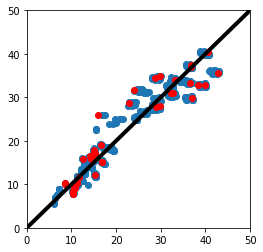

In [28]:
# train linear model 
MLR=linear_model.LinearRegression()
MLR.fit(train[train.columns.values[0:8]],train[train.columns.values[8]])

# make predictions on test and train set 
trainpred=MLR.predict(train[train.columns.values[0:8]])
testpred=MLR.predict(test[train.columns.values[0:8]])

#make parity plot 
plt.figure(figsize=(4,4))
plt.xlim([0,50]);
plt.ylim([0,50]);
plt.scatter(train[train.columns.values[8]],trainpred)
plt.scatter(test[train.columns.values[8]],testpred,color='r')
plt.plot([0,50],[0,50],lw=4,color='black')

#calculate the test and train error
print("Train error",mean_squared_error(train[train.columns.values[8]],trainpred))
print("Test error",mean_squared_error(test[train.columns.values[8]],testpred))

# Part 2: Ridge Regression (same data as Part 1)

* The Ridge coefficients minimize $RSS + \lambda \sum_{j=1}^{p}\beta_j^2$
    * There is an additional **penalty** in error for having nonzero coefficients!
* Note: Eq 6.5 in ISLR shows the tuning parameter as $\lambda$, it is $\alpha$ in SKLearn
* Goal here: train models as a function of the regularization parameter 
* The X's should be normalized as in Eq 6.6, there is a normalization feature, but we will do it manually using $x_{ij}=\frac{x_{ij}}{s_j}$
    * I suggest on your own you test out what normalization in Ridge does
    * Some methods in sklearn also do automatic selection of shrinkage coefficient! Cool! 

In [29]:
#normalized data for Ridge / LASSO 
train_normalized=train/train.std()
test_normalized=test/test.std()


## 2-1 Example of single instance of RR


In [30]:
heat_ridge=Ridge()
a=1e0
heat_ridge.set_params(alpha=a)
heat_ridge.fit(train_normalized[train.columns.values[0:8]],train_normalized[train.columns.values[8]])


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [33]:
print (mean_squared_error(train_normalized[train.columns.values[8]],heat_ridge.predict(
        train_normalized[train.columns.values[0:8]])))

print (mean_squared_error(test_normalized[train.columns.values[8]],heat_ridge.predict(
        test_normalized[train.columns.values[0:8]])))

0.0818431981700994
1.2492152051781893


## 2-2 Example of searching the $\alpha$ space in RR

In [36]:
# RR vs lambda (based on sklearn tutorial)
coefs = []
trainerror = []
testerror = []

# do you know what is happening here? 
lambdas = np.logspace(-6,6,200)
model=Ridge()

# loop over lambda values (strength of regularization)
for l in lambdas:
    model.set_params(alpha=l)
    model.fit(train_normalized[train.columns.values[0:8]],train_normalized[train.columns.values[8]])
    coefs.append(model.coef_)
    trainerror.append(mean_squared_error(train_normalized[train.columns.values[8]],model.predict(
        train_normalized[train.columns.values[0:8]])))
    testerror.append(mean_squared_error(test_normalized[train.columns.values[8]],model.predict(
        test_normalized[train.columns.values[0:8]])))

    

Text(0.5,1,'error vs $\\lambda$')

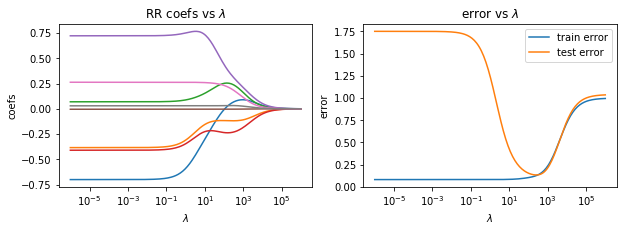

In [37]:
# what is being plotted here? 
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(lambdas,coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('coefs')
plt.title('RR coefs vs $\lambda$')
plt.subplot(122)
plt.plot(lambdas,trainerror,label='train error')
plt.plot(lambdas,testerror,label='test error')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('error')
plt.legend(loc=1)
plt.title('error vs $\lambda$')


### RR questions 

1) Explain to each other what is happening in these two plots   
2) Why does the blue curve have a minimum at the smallest $\lambda$ value? 

# Part 3: LASSO regression  (same data as Part 1)

* The lasso improves over ridge by also providing a variable selection tool!
* The lasso minimizer is $RSS + \lambda \sum_{j=1}^{p}\lvert\beta_j\rvert$

In [38]:
# also based on sklearn tutorials
# what the hell is happening in this cell?
coefs = []
trainerror = []
testerror = []

lambdas = np.logspace(-6,6,200)
model=linear_model.Lasso()

# loop over lambda values (strength of regularization)
for l in lambdas:
    model.set_params(alpha=l,max_iter=1e6)
    model.fit(train_normalized[train.columns.values[0:8]],train_normalized[train.columns.values[8]])
    coefs.append(model.coef_)
    trainerror.append(mean_squared_error(train_normalized[train.columns.values[8]],model.predict(
        train_normalized[train.columns.values[0:8]])))
    testerror.append(mean_squared_error(test_normalized[train.columns.values[8]],model.predict(
        test_normalized[train.columns.values[0:8]])))



Text(0.5,1,'error vs $\\lambda$')

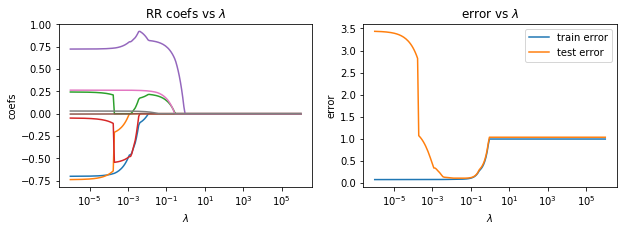

In [39]:
plt.figure(figsize=(10,3))
#plt.locator_params(nbins=5)
plt.subplot(121)
plt.plot(lambdas,coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('coefs')
plt.title('RR coefs vs $\lambda$')
#plt.xlim(1e-4,1e0)

plt.subplot(122)
plt.plot(lambdas,trainerror,label='train error')
plt.plot(lambdas,testerror,label='test error')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('error')
#plt.xlim(1e-4,1e0)
#plt.ylim(0,0.5)
plt.legend(loc=1)
plt.title('error vs $\lambda$')

### Other things to consider if you have more time 

* Note we did not scale the features in the MLR, try it out and verify the final error doesnt' change!
* Make sure you undersand how to make _predictions_ with supervised learning models that are trained on scaled/normalized data
* Plot the residuals and verify if errors are distributed normally
* Make a parity plot including the predictions from ridge and LASSO 
* Compare errors between all three 
* Explore the effect of training/testing split 
* Look at the shrinkage/regularization situation when predicting Y2 vs Y1... 
